In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/santander-customer-transaction-prediction-dataset/train.csv
/kaggle/input/santander-customer-transaction-prediction-dataset/test.csv


### 1. Variance Threshold

Variance threshold from sklearn is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples.
The Variance Threshold feature selection only sees the input features (X) without considering any information from the dependent variable (y).

In [2]:
train= pd.read_csv("../input/santander-customer-transaction-prediction-dataset/train.csv")
test= pd.read_csv("../input/santander-customer-transaction-prediction-dataset/test.csv")

#Remove Target column before performing Feature Selection with Variance Threshold Method
X_train= train.drop(labels=["ID_code",'target'], axis=1)
X_test= test.drop(labels=["ID_code"], axis=1)

y_train= train[["target"]]

print(X_train.shape)
print(X_test.shape)

(200000, 200)
(200000, 200)


In [3]:
from sklearn.feature_selection import VarianceThreshold
#Removing both constant and quasi-constant
vt = VarianceThreshold(threshold=0.1)
vt.fit(X_train)  # fit finds the features with zero variance

# get_support is a boolean vector that indicates which features are retained
# Finding non-constant features
len(X_train.columns[vt.get_support()])

190

Be careful while selecting the threshold. For example, if we are working with Cancer dataset and our target variable has distribution 90%-10%, then it will not be wise to have threshold 0.1

In [4]:
# print the constant features
cols_removed = [x for x in X_train.columns if x not in X_train.columns[vt.get_support()]]

#Print columns selected by Variance Threshold
# print the constant features
cols_selected = [x for x in X_train.columns[vt.get_support()]]
print("Columns Removed are: ")
print(cols_removed, "\n")
print("Columns Selected are: ")
print(cols_selected)

Columns Removed are: 
['var_12', 'var_25', 'var_43', 'var_68', 'var_71', 'var_91', 'var_103', 'var_108', 'var_148', 'var_161'] 

Columns Selected are: 
['var_0', 'var_1', 'var_2', 'var_3', 'var_4', 'var_5', 'var_6', 'var_7', 'var_8', 'var_9', 'var_10', 'var_11', 'var_13', 'var_14', 'var_15', 'var_16', 'var_17', 'var_18', 'var_19', 'var_20', 'var_21', 'var_22', 'var_23', 'var_24', 'var_26', 'var_27', 'var_28', 'var_29', 'var_30', 'var_31', 'var_32', 'var_33', 'var_34', 'var_35', 'var_36', 'var_37', 'var_38', 'var_39', 'var_40', 'var_41', 'var_42', 'var_44', 'var_45', 'var_46', 'var_47', 'var_48', 'var_49', 'var_50', 'var_51', 'var_52', 'var_53', 'var_54', 'var_55', 'var_56', 'var_57', 'var_58', 'var_59', 'var_60', 'var_61', 'var_62', 'var_63', 'var_64', 'var_65', 'var_66', 'var_67', 'var_69', 'var_70', 'var_72', 'var_73', 'var_74', 'var_75', 'var_76', 'var_77', 'var_78', 'var_79', 'var_80', 'var_81', 'var_82', 'var_83', 'var_84', 'var_85', 'var_86', 'var_87', 'var_88', 'var_89', 'var_90

In [5]:
X_train = vt.transform(X_train)
X_test = vt.transform(X_test)

# Converting numpy array to pandas dataframe
X_train= pd.DataFrame(X_train,columns= cols_selected)
X_test= pd.DataFrame(X_test,columns= cols_selected)

# check the shape of training and test set
X_train.shape, X_test.shape

((200000, 190), (200000, 190))

### 2. Univariate Methods

Univariate feature selection works by selecting the best features using univariate statistical tests such as chi-square. It examines each feature individually to determine the strength of the relationship of the feature with the response variable. It can be seen as a preprocessing step to an estimator. 
- For regression tasks: f_regression, mutual_info_regression
- For classification tasks: chi2, f_classif, mutual_info_classif

There are 4 methods that fall under this category :-
- SelectKBest : SelectKBest is one of the univariate methods which removes all but the specified number of highest scoring features. 
- SelectPercentile
- SelectFpr, SelectFdr, or family wise error SelectFwe
- GenericUnivariateSelection

In [6]:
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
print(X.shape)
X= pd.DataFrame(X)
y=pd.DataFrame(y, columns=["target"])
X.head()

(150, 4)


,0,1,2,3
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


### 2.1 Chi Square Test

- It is the chi-square implementation in scikit-learn. It computes chi-squared stats between each non-negative feature and class.
- This score should be used to evaluate categorical variables in a classification task. It compares the observed distribution of the different classes of target Y among the different categories of the feature, against the expected distribution of the target classes, regardless of the feature categories.

**SelectKBest**: This method select features according to the k highest scores.

In [7]:
from sklearn.feature_selection import SelectKBest, chi2

X_k_best= SelectKBest(chi2, k=2).fit(X, y)


mask = X_k_best.get_support() #list of booleans for selected features
new_feat = [] 
for bool, feature in zip(mask, X.columns):
    if bool:
        new_feat.append(feature)
print("The best features are:{}".format(new_feat)) # The list of your k best features

The best features are:[2, 3]


**SelectPercentile** : Select features according to a percentile of the highest scores.

In [8]:
from sklearn.feature_selection import SelectPercentile, chi2
# now select features based on top 50 percentile
X_new = SelectPercentile(chi2, percentile=50).fit_transform(X, y)

X_new.shape

(150, 2)

### 2.2 F-Test

- Compute the ANOVA F-value for the provided sample.
- If the features are categorical, we will calculate a chi-square statistic between each feature and the target vector. However, if the features are quantitative, we will compute the ANOVA F-value between each feature and the target vector.
- The F-value scores examine if, when we group the numerical feature by the target vector, the means for each group are significantly different.

In [9]:
from sklearn.feature_selection import f_classif
sel_f = SelectKBest(f_classif, k=2)
X_f = sel_f.fit_transform(X, y)
print(sel_f.get_support())

[False False  True  True]


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### 2.3 Mutual Information Test

- Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. 
- The MI score will fall in the range from 0 to ∞. The higher value, the closer connection between this feature and the target, which suggests that we should put this feature in the training dataset. If the MI score is 0 or very low like 0.01. the low score suggests a weak connection between this feature and the target.
- This function relies on nonparametric methods based on entropy estimation from k-nearest neighbors distances.
- It can be used for univariate features selection.
- Mutual Information measures the entropy drops under the condition of the target value.
- MI(feature;target) = Entropy(feature) - Entropy(feature|target)


In [10]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

In [11]:
selector = SelectKBest(mutual_info_classif, k=2)
#selector = SelectPercentile(mutual_info_classif, percentile=50)
X_mutual = selector.fit_transform(X, y)
print(X_mutual.shape)


cols = selector.get_support(indices=True)
cols

(150, 2)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([2, 3])

### 3. Recursive Feature Elimination


- Recursive feature elimination (RFE) is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. Features are ranked by the model’s coef_ or feature_importances_ attributes, and by recursively eliminating a small number of features per loop, RFE attempts to eliminate dependencies and collinearity that may exist in the model.
- RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.
- This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.
- There are two important configuration options when using RFE: the choice in the number of features to select and the choice of the algorithm used to help choose features.
- step: step corresponds to the number of features to remove at each iteration. modifying the step parameter to eliminate more than one feature at each step may help to eliminate the worst features early, strengthening the remaining features (and can also be used to speed up feature elimination for datasets with a large number of features).

In [12]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import fetch_california_housing
from numpy import array


In [13]:
housing = fetch_california_housing()
x = housing.data
y = housing.target

print("Feature data dimension: ", x.shape)

estimator = AdaBoostRegressor(random_state=0, n_estimators=100)
selector = RFE(estimator, n_features_to_select=4, step=1)
selector = selector.fit(x, y)
 
filter = selector.support_
ranking = selector.ranking_

print("Mask data: ", filter)
print("Ranking: ", ranking)

features = array(housing.feature_names)
print("All features:")
print(features)

print("Selected features:")
print(features[filter])   
 

Feature data dimension:  (20640, 8)
Mask data:  [ True False False False False  True  True  True]
Ranking:  [1 4 2 5 3 1 1 1]
All features:
['MedInc' 'HouseAge' 'AveRooms' 'AveBedrms' 'Population' 'AveOccup'
 'Latitude' 'Longitude']
Selected features:
['MedInc' 'AveOccup' 'Latitude' 'Longitude']


### 4. Recursive Feature Elimination with Cross-Validation


RFE requires a specified number of features to keep, however it is often not known in advance how many features are valid. To find the optimal number of features cross-validation is used with RFE to score different feature subsets and select the best scoring collection of features. The RFECV visualizer plots the number of features in the model along with their cross-validated test score and variability and visualizes the selected number of features.<br>
How RFECV works:<br>
Say you run a 3-fold RFECV. For each split, the train set will be transformed by RFE n times (for each possible 1..n number of features). The classifier supplied will be trained on the training set, and a score will be computed on the test set. Eventually, for each 1..n number of features, the mean result from the 3 different splits is shown on the graph you included. Then, RFEVC transforms the entire set using the best scoring number of features. The ranking you see is based on that final transformation.<br>

Source: https://stats.stackexchange.com/questions/305191/understanding-cross-validated-recursive-feature-elimination/305195#305195?newreg=adb632b7ae834db7a004f0498becda43

Using Yellowbrick

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

from yellowbrick.model_selection import RFECV
from yellowbrick.datasets import load_credit

# Load classification dataset
X, y = load_credit()
X.shape

(30000, 23)

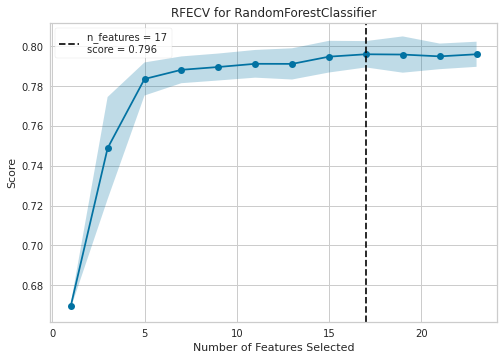

Optimal number of features : 17


In [15]:
min_features_to_select = 1
cv = StratifiedKFold(3)
visualizer = RFECV(RandomForestClassifier(),step=2, cv=cv, scoring='f1_weighted', min_features_to_select=min_features_to_select)

visualizer.fit(X, y)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure
print("Optimal number of features : %d" % visualizer.n_features_)

In [16]:
filter= visualizer.support_
#print(filter)
features = array(X.columns)
print("All features:")
print(features)

print("Selected features:")
print(features[filter])   
 

All features:
['limit' 'sex' 'edu' 'married' 'age' 'apr_delay' 'may_delay' 'jun_delay'
 'jul_delay' 'aug_delay' 'sep_delay' 'apr_bill' 'may_bill' 'jun_bill'
 'jul_bill' 'aug_bill' 'sep_bill' 'apr_pay' 'may_pay' 'jun_pay' 'jul_pay'
 'aug_pay' 'sep_pay']
Selected features:
['limit' 'age' 'apr_delay' 'may_delay' 'jun_delay' 'apr_bill' 'may_bill'
 'jun_bill' 'jul_bill' 'aug_bill' 'sep_bill' 'apr_pay' 'may_pay' 'jun_pay'
 'jul_pay' 'aug_pay' 'sep_pay']


p.s. this method was really slow. Hence, use it only when high computational power is available or when we are working with smaller datasets

### 5. Forward Selection

- Forward selection is an iterative method in which we start with having no feature in the model. In each iteration, we keep adding the feature which best improves our model till an addition of a new variable does not improve the performance of the model.
- The procedure starts with an empty set of features [reduced set]. The best of the original features is determined and added to the reduced set. At each subsequent iteration, the best of the remaining original attributes is added to the set.
- Step forward feature selection starts by evaluating all features individually and selects the one that generates the best performing algorithm, according to a pre-set evaluation criteria. In the second step, it evaluates all possible combinations of the selected feature and a second feature, and selects the pair that produce the best performing algorithm based on the same pre-set criteria.
- The pre-set criteria can be the roc_auc for classification and the r squared for regression for example.
- This selection procedure is called greedy, because it evaluates all possible single, double, triple and so on feature combinations. Therefore, it is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.
- There is a special package for python that implements this type of feature selection: mlxtend.
- In the mlxtend implementation of the step forward feature selection, the stopping criteria is an arbitrarily set number of features. So the search will finish when we reach the desired number of selected features.
- Python Example Source: https://www.analyticsvidhya.com/blog/2021/04/forward-feature-selection-and-its-implementation/

**Using mlxtend library**

In [17]:
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from sklearn.linear_model import LinearRegression

housing = fetch_california_housing()
X = pd.DataFrame(housing.data)
y = pd.DataFrame(housing.target, columns=["target"])
# calling the linear regression model

lreg = LinearRegression()
sfs1 = sfs(lreg, k_features=4, forward=True, verbose=1, scoring='neg_mean_squared_error')
# For Backward Elimination method, we set forward= False while everything else remains same

sfs1 = sfs1.fit(X, y)
feat_names = list(sfs1.k_feature_names_)

print(X.shape)
print(X.head())
print(y.head())
print(feat_names)

# creating a new dataframe using the above variables and adding the target variable
new_data = X[feat_names]
# first five rows of the new data
new_data.head()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.2s finished
Features: 1/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.2s finished
Features: 2/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s finished
Features: 3/4[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
Features: 4/4

(20640, 8)
        0     1         2         3       4         5      6       7
0  8.3252  41.0  6.984127  1.023810   322.0  2.555556  37.88 -122.23
1  8.3014  21.0  6.238137  0.971880  2401.0  2.109842  37.86 -122.22
2  7.2574  52.0  8.288136  1.073446   496.0  2.802260  37.85 -122.24
3  5.6431  52.0  5.817352  1.073059   558.0  2.547945  37.85 -122.25
4  3.8462  52.0  6.281853  1.081081   565.0  2.181467  37.85 -122.25
   target
0   4.526
1   3.585
2   3.521
3   3.413
4   3.422
[0, 1, 2, 3]


,0,1,2,3
0,8.3252,41.0,6.984127,1.023810
1,8.3014,21.0,6.238137,0.971880
2,7.2574,52.0,8.288136,1.073446
3,5.6431,52.0,5.817352,1.073059
4,3.8462,52.0,6.281853,1.081081


**Using sklearn**

In [18]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
X, y = load_iris(return_X_y=True)
knn = KNeighborsClassifier(n_neighbors=3)
sfs = SequentialFeatureSelector(knn, n_features_to_select=3, direction='forward')
sfs.fit(X, y)
SequentialFeatureSelector(estimator=KNeighborsClassifier(n_neighbors=3),
                          n_features_to_select=3)
print(sfs.get_support())
print(sfs.transform(X).shape)

[ True False  True  True]
(150, 3)


### 6. Select From Model

- SelectFromModel is a meta-transformer that can be used alongside any estimator that assigns importance to each feature through a specific attribute (such as coef_, feature_importances_) or via an importance_getter callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter. 
- threshold: If “median” (resp. “mean”), then the threshold value is the median (resp. the mean) of the feature importances. A scaling factor (e.g., “1.25*mean”) may also be used. 
- One can use the max_features parameter to set a limit on the number of features to select.
- Compared to univariate feature selection, model-based feature selection consider all feature at once, thus can capture interactions. The model used for the feature selection doesn’t need to be the same model for the training later.

**6.1 L-1 Based**

Regularisation consists in adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model and in other words to avoid overfitting. In linear model regularisation, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularisation, Lasso or l1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [19]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, y)
model = SelectFromModel(estimator=lsvc, prefit= True)
X_new = model.transform(X)
print(model.get_support())

[ True  True  True False]


/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


**6.2 Tree-Based**

- For classification, the measure of impurity is either the Gini impurity or the information gain/entropy. For regression the measure of impurity is variance. Therefore, when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable.
- To give a better intuition, features that are selected at the top of the trees are in general more important than features that are selected at the end nodes of the trees, as generally the top splits lead to bigger information gains.

A good approach to estimate the best threshold:
- start with a low threshold, for example: 1e-4
- reduce your features using SelectFromModel fit & transform
- compute metrics (accuracy, etc.) for your estimator (RandomForestClassifier in your case) for selected features
- increase threshold and repeat all steps starting from point 1.
Source: https://stackoverflow.com/questions/49345578/how-to-decide-threshold-value-in-selectfrommodel-for-selecting-features

In [20]:
model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X, y)
print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean')  
      # since we already fit the data, we specify prefit option here
      # Features whose importance is greater or equal to the threshold are kept while the others are discarded.
X_new = sel_model_tree.transform(X)
print(sel_model_tree.get_support())

[0.09004865 0.01591824 0.41934095 0.47469216]
[False False  True  True]


### 7. Exhaustive Feature Selection

- In an exhaustive feature selection the best subset of features is selected, over all possible feature subsets, by optimizing a specified performance metric for a certain machine learning algorithm. For example, if the classifier is a logistic regression and the dataset consists of 4 features, the algorithm will evaluate all 15 feature combinations as follows:<br>
all possible combinations of 1 feature<br>
all possible combinations of 2 features<br>
all possible combinations of 3 features<br>
all the 4 features<br>
and select the one that results in the best performance (e.g., classification accuracy) of the logistic regression classifier.
- This is another greedy algorithm as it evaluates all possible feature combinations. It is quite computationally expensive, and sometimes, if feature space is big, even unfeasible.
- It is not common in real-world applications. Therefore, we will  **NOT** implement it here

**Final Notes:** <br>
For a Machine Learning problem with a large number of columns, usually a good approach would be:
1. Start with removing low variance columns using Variance Threshold Method.
2. Then perform univariate analyses for each of the independent variables with respect to the target variable using some Statistical test (like chi-square etc.). Using this method, we can extract top k features (or features based on top nth percentile).
3. Optional: If dataset is small, them we may perform some sequential feature selection method like RFE. However, this will be computationally expensive for larger datasets and hence may be avoided in such cases.
3. Thereafter, we may implement multi-variate feature selection method so that we also account for the interaction between all features. SelectFromModel should be the final method in this approach.

References:
- https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection
- https://scikit-learn.org/stable/modules/feature_selection.html
